## Exercise 5 BLOB Analysis

The purpose of this exercise is to implement, test and validate connected component analysis methods. Also known as BLOB (binary large object) analysis.

The methods will be used to create a small program that can count cell nuclei.

In [1]:
from skimage import io, color, morphology
from skimage.util import img_as_float, img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np
import math
from skimage.filters import threshold_otsu
from skimage import segmentation
from skimage import measure
from skimage.color import label2rgb

from skimage.morphology import disk, binary_opening, binary_closing

In [2]:
def show_comparison(original, modified, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(modified)
    ax2.set_title(modified_name)
    ax2.axis('off')
    io.show()

### Exercise 1: Binary image from original image
Read the image, convert it to grayscale and use Otsus method to compute and apply a threshold.

Show the binary image together with the original image.

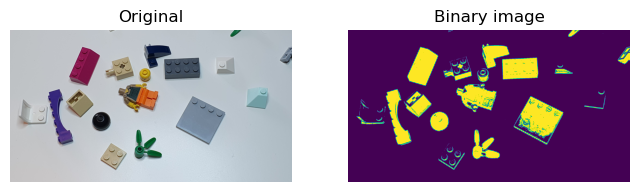

In [3]:
# read image
lego = io.imread("data/lego_4_small.png")
# convert to gray scale
lego_gray = color.rgb2gray(lego.copy())
# find threshold with Otsu
thresh = threshold_otsu(lego_gray)
# Apply the threshold and cretae a binary image
lego_bin = lego_gray < thresh

# plotting using their function
show_comparison(lego, lego_bin, 'Binary image')

### Exercise 2: Remove border BLOBs
Use segmentation.clear_border to remove border pixels from the binary image.

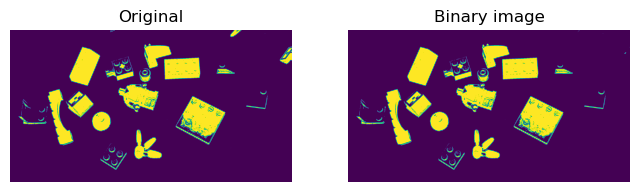

In [4]:
lego_segment = segmentation.clear_border(lego_bin)
show_comparison(lego_bin,lego_segment, 'Binary image')

### Exercise 3: Cleaning using morphological operations
In order to remove remove noise and close holes, you should do a morphological closing followed by a morphological opening with a disk shaped structuring element with radius 5. See Exercise 4b if you are in doubt.

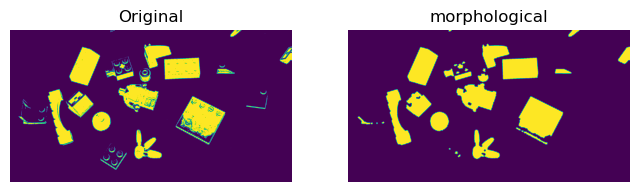

In [5]:
lego_close = binary_closing(lego_bin, disk(5))
lego_open = binary_opening(lego_close, disk(5))
show_comparison(lego_bin, lego_open, 'morphological')

### Exercise 4: Find labels
The actual connected component analysis / BLOB analysis is performed using measure.label :

In [6]:
label_img = measure.label(lego_open)
n_labels = label_img.max()
print(f"Number of labels: {n_labels}")

Number of labels: 32


### Exercise 5: Visualize found labels
We can use the function label2rbg to create a visualization of the found BLOBS. Show this together with the original image.

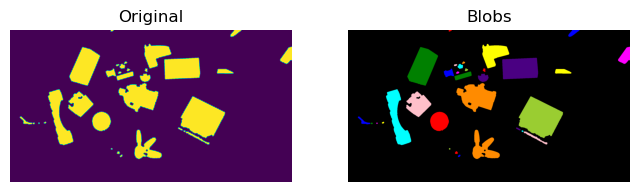

In [7]:
lego_lab = label2rgb(label_img)
show_comparison(lego_open, lego_lab, 'Blobs')

### Exericse 6: Compute BLOB features
It is possible to compute a wide variety of BLOB features using the measure.regionprops function:

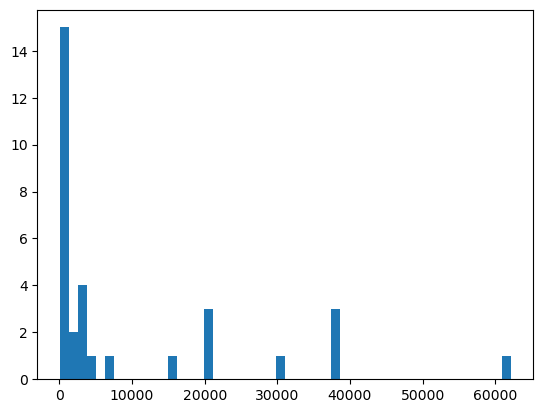

In [8]:
region_props = measure.regionprops(label_img)
areas = np.array([prop.area for prop in region_props])
plt.hist(areas, bins=50)
plt.show()

### Exercise 7: Exploring BLOB features
There is an example program called Ex5-BlobAnalysisInteractive.py in the exercise material folder.

With that program, you can explore different BLOB features interactively. It requires installation of plotly:

In [9]:
# uncomment below to user interactive blob analysis
#!python Ex5-BlobAnalysisInteractive.py

## Working with Cell Counting 
The raw images from the Cytometer are 1920x1440 pixels and each pixel is 16 bit (values from 0 to 65535). The resolution is 1.11  / pixel.

To make it easier to develop the cell counting program we start by working with smaller areas of the raw images. The images are also converted to 8 bit grayscale images:

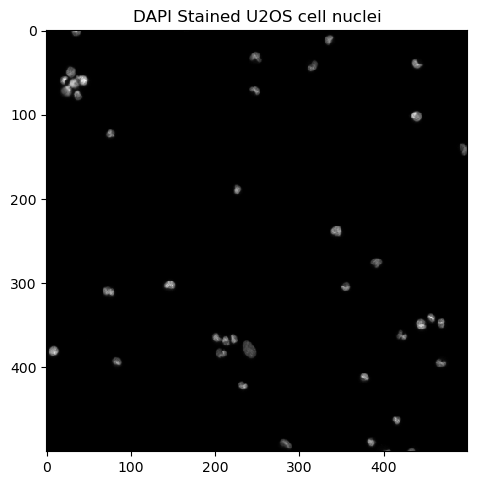

In [10]:
in_dir = "data/"
U2OS_DAPI = io.imread(in_dir + 'Sample E2 - U2OS DAPI channel.tiff')
# slice to extract smaller image
U2OS_DAPI_small = U2OS_DAPI.copy()[700:1200, 900:1400]
U2OS_DAPI_gray = img_as_ubyte(U2OS_DAPI_small) 
io.imshow(U2OS_DAPI_gray, vmin=0, vmax=150)
plt.title('DAPI Stained U2OS cell nuclei')
io.show()

As can be seen we use slicing to extract a part of the image. You can use vmin and vmax to visualise specific gray scale ranges (0 to 150 in the example above). Adjust these limits to find out where the cell nuclei are most visible.

Initially, we would like to apply a threshold to create a binary image where nuclei are foreground. To select a good threshold, inspect the histogram:

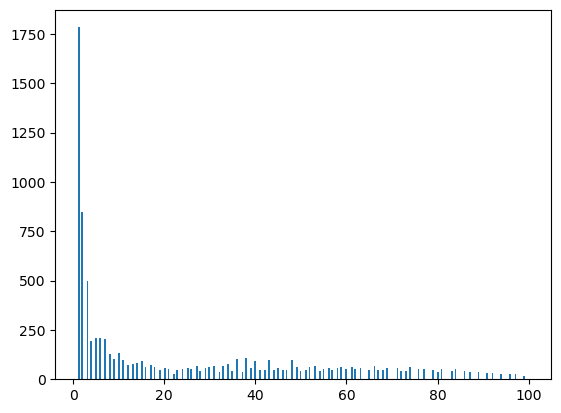

In [11]:
# avoid bin with value 0 due to the very large number of background pixels
plt.hist(U2OS_DAPI_gray.ravel(), bins=256, range=(1, 100))
io.show()

### Exercise 8: Threshold selection
Select an appropriate threshold, that seperates nuclei from the background. You can set it manually or use Otsus method.

Show the binary image together with the original image and evaluate if you got the information you wanted in the binary image.

It can be seen that there is some noise (non-nuclei) present and that some nuclei are connected. Nuclei that are overlapping very much should be discarded in the analysis. However, if they are only touching each other a little we can try to separate them. More on this later.

To make the following analysis easier the objects that touches the border should be removed.

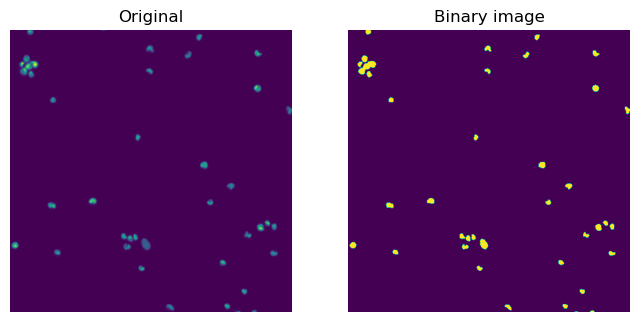

In [12]:
U2OS_DAPI_thresh = threshold_otsu(U2OS_DAPI_gray)
U2OS_DAPI_bin = U2OS_DAPI_gray.copy() > U2OS_DAPI_thresh
show_comparison(U2OS_DAPI_gray, U2OS_DAPI_bin, 'Binary image')

### Exercise 9: Remove border BLOBS
Use segmentation.clear_border to remove border pixels from the binary image.

To be able to analyse the individual objects, the objects should be labelled.

In this image, each object has a separate color - does it look reasonable?

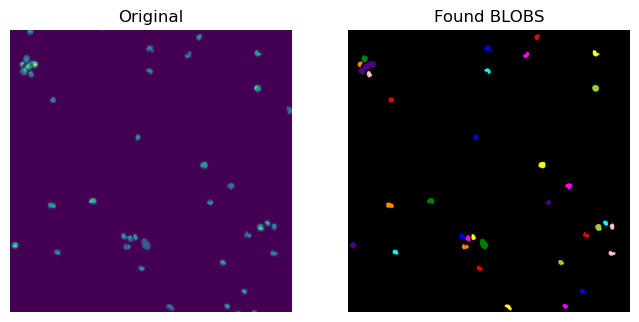

In [13]:
U2OS_DAPI_c_b = segmentation.clear_border(U2OS_DAPI_bin)
label_U2OS_DAPI = measure.label(U2OS_DAPI_c_b)
U2OS_DAPI_label_overlay = label2rgb(label_U2OS_DAPI)
show_comparison(U2OS_DAPI_gray, U2OS_DAPI_label_overlay, 'Found BLOBS')

### Exercise 10: BLOB features
The task is now to find some object features that identify the cell nuclei and let us remove noise and connected nuclei. We use the function regionprops to compute a set of features for each object:

In [14]:
region_props = measure.regionprops(label_U2OS_DAPI)
print(region_props[0].area)

71


For example can the area of the first object be seen by: print(region_props[0].area).

A quick way to gather all areas is the code below. 

We can try if the area of the objects is enough to remove invalid object. Plot a histogram of all the areas and see if it can be used to identify well separated nuclei from overlapping nuclei and noise. You should probably play around with the number of bins in your histogram plotting function.

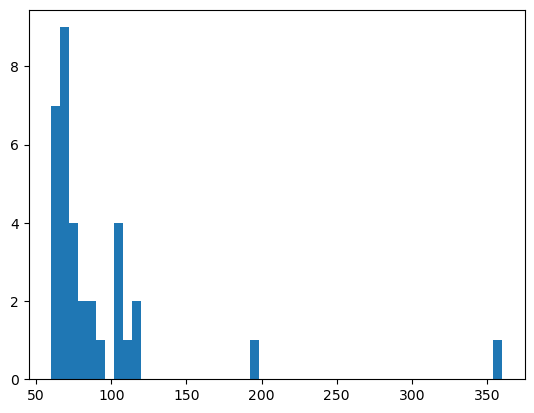

In [15]:
areas = np.array([prop.area for prop in region_props])
plt.hist(areas, bins = 50)
plt.show()

### Exercise 11: BLOB classification by area
Select a minimum and maximum allowed area and use the following to visualise the result:

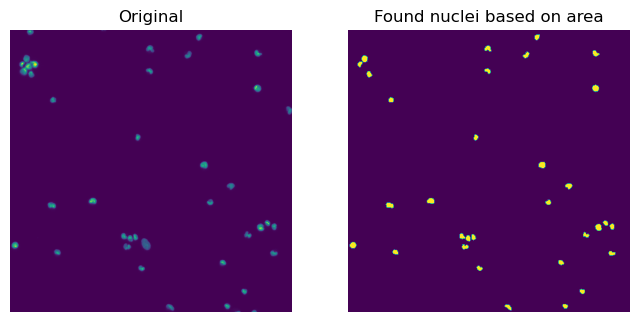

In [16]:
min_area = 10
max_area = 150

# Create a copy of the label_img
label_img_filter = label_U2OS_DAPI
for region in region_props:
	# Find the areas that do not fit our criteria
	if region.area > max_area or region.area < min_area:
		# set the pixels in the invalid areas to background
		for cords in region.coords:
			label_img_filter[cords[0], cords[1]] = 0
# Create binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(U2OS_DAPI_small, i_area, 'Found nuclei based on area')

### Exercise 12: Feature space
Extract all the perimeters of the BLOBS:

Try to plot the areas versus the perimeters.

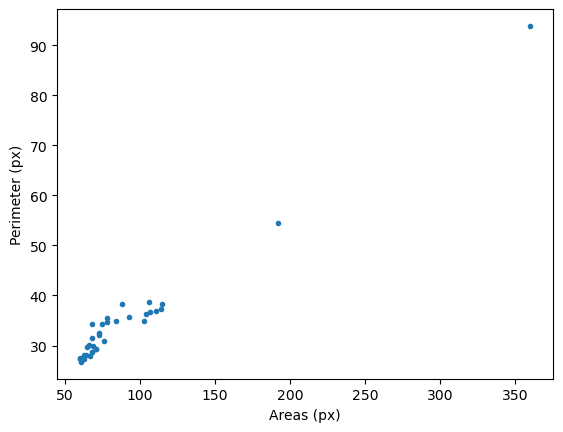

In [17]:
perimeters = np.array([prop.perimeter for prop in region_props])

fig, ax = plt.subplots(1,1)
ax.plot(areas, perimeters, '.')
ax.set_xlabel('Areas (px)')
ax.set_ylabel('Perimeter (px)')
plt.show()

### Exercise 13: BLOB Circularity
We should also examine if the shape of the cells can identify them. A good measure of how circular an object is can be computed as:

$$f_{circ} =\frac{4\pi A}{P^2}$$

where $A$ is the object area and $P$ is the perimeter. A circle has a circularity close to 1, and very-non-circular object have circularity close to 0.

Compute the circularity for all objects and plot a histogram.

Select some appropriate ranges of accepted circularity. Use these ranges to select only the cells with acceptable areas and circularity and show them in an image.

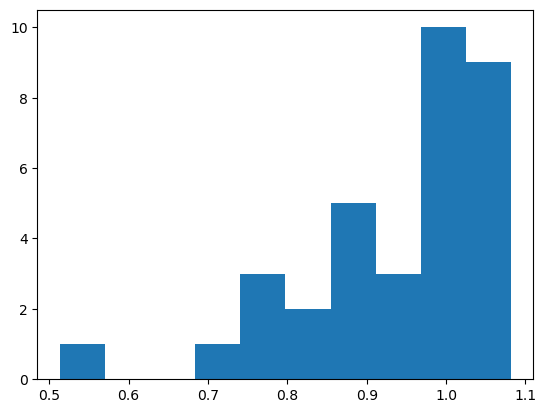

In [18]:
def circular(A,P):
    return (4*math.pi*A)/pow(P,2)
# first way to do it withjust the whole array
circularity = circular(areas,perimeters)

# Second way to do it, with each element in the array
circular_array = []
for i in range(len(areas)):
    circular_array.append(circular(areas[i], perimeters[i]))
# plot of first and second method are the same and shown here. 
plt.hist(circular_array, bins = 10)
plt.show()

# From the plot a good cut of point could be bigger than 0.75

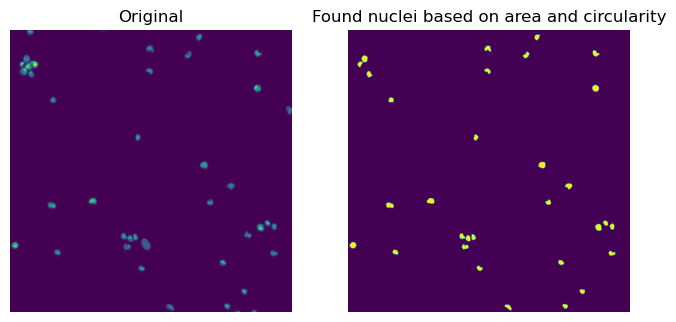

In [19]:
# showing only the acceptable nucli 
min_circ = 0.75
# Create a copy of the label_img
label_img_filter = label_U2OS_DAPI
for region in region_props:
	circ = circular(region.area, region.perimeter)
	# Find the areas that do not fit our criteria
	if region.area > max_area or region.area < min_area or circ < min_circ:
		# set the pixels in the invalid areas to background
		for cords in region.coords:
			label_img_filter[cords[0], cords[1]] = 0
# Create binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(U2OS_DAPI_small, i_area, 'Found nuclei based on area and circularity')

### Exercise 14: BLOB circularity and area
Try to plot the areas versus the circularity. What do you observe?

Extend your method to return the number (the count) of well-formed nuclei in the image.

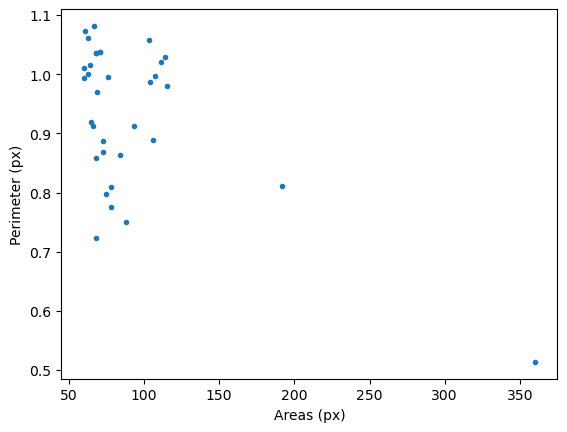

In [20]:
fig, ax = plt.subplots(1,1)
ax.plot(areas, circularity, '.')
ax.set_xlabel('Areas (px)')
ax.set_ylabel('Perimeter (px)')
plt.show()